In [1]:
import numpy as np 
import random 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch import optim 
from torch.autograd import Variable 

In [2]:
def to_var(x):
	if torch.cuda.is_available():
		x = x.cuda()
	return Variable(x)

In [119]:
# generate sequence with multiple greater subsequences
def generate_single_seq_multiple(length=72, min_len=4, max_len=8, max_pointer=4):
	'''
	generates a sequence of numbers of random length
	and inserts a sub-seqeunce of greater numbers at random place
	output:
	seqeunce of numbers, index of the start and end of the greater number subsequence

	alternate: small, big, small, ...
	'''
	seq = []
	pos = []
	ptr_num = random.randint(1, max_pointer)
	for i in range(ptr_num):	
		temp_seq_small = [random.randint(1, 5) for x in range(random.randint(min_len, max_len))]
		temp_seq_big = [random.randint(6, 10) for x in range(random.randint(min_len, max_len))]
		seq += temp_seq_small
		pos1 = len(seq)
		seq += temp_seq_big
		pos2 = len(seq) - 1
		pos.extend([pos1, pos2])
	temp_seq_small = [random.randint(1, 5) for x in range(random.randint(min_len, max_len))]
	seq += temp_seq_small

	# pad to keep constant input seq length 
	seq = seq + ([0] * (length - len(seq)))
	return (seq, pos, ptr_num*2)

def generate_set_seq_multiple(N):
	# generate a set of N sequences of fixed lengths
	data = []    #(N, L)
	pos = []	 #(N, ptr*2)
	ptr_nums = []  #(N)
	for i in range(N):
		seq, seq_pos, seq_ptr = generate_single_seq_multiple()
		data.append(seq)
		pos.append(seq_pos)
		ptr_nums.append(seq_ptr)
	return data, (pos, ptr_nums)

In [158]:
class PointerNetwork(nn.Module):
    def __init__(self, input_size, emb_size, weight_size, hidden_size=512, is_GRU=True):
        super(PointerNetwork, self).__init__()

        self.hidden_size = hidden_size 
        self.input_size = input_size 
        self.emb_size = emb_size 
        self.weight_size = weight_size 
        self.is_GRU = is_GRU

        self.emb = nn.Embedding(input_size, emb_size)
        if is_GRU:
            self.enc = nn.GRU(emb_size, hidden_size, batch_first=True)
            self.dec = nn.GRUCell(emb_size, hidden_size)
        else:
            self.enc = nn.LSTM(emb_size, hidden_size, batch_first=True)
            self.dec = nn.LSTMCell(emb_size, hidden_size)

        self.W1 = nn.Linear(hidden_size, weight_size, bias=False)
        self.W2 = nn.Linear(hidden_size, weight_size, bias=False)
        self.vt = nn.Linear(weight_size, 1, bias=False) 
        self.WL = nn.Linear(hidden_size, 1, bias=False)

    # batch size has to be 1 because each sequence has a different decoder length
    def forward(self, input):
        batch_size = 1
        input = self.emb(input) #(B, len, emb)

        encoder_states, hc = self.enc(input) #encoder_states: (B, L, hid)  hc:(B, hid)
        encoder_states = encoder_states.transpose(1, 0) #(L, B, hid)

        pred_L = self.WL(hc).squeeze()  #(B)
        answer_seq_len = round(pred_L.item())

        decoder_input = to_var(torch.zeros(batch_size, self.emb_size))
        hidden = to_var(torch.zeros([batch_size, self.hidden_size])) #(B, hid)
        cell_state = encoder_states[-1] #(B, hid)

        probs = []
        # decoding
        for i in range(answer_seq_len):
            if self.is_GRU:
                hidden = self.dec(decoder_input, hidden)
            else:
                hidden, cell_state = self.dec(decoder_input, (hidden, cell_state))

            # compute blended representation at each decoder time step
            blend1 = self.W1(encoder_states)    #(L, B, W)
            blend2 = self.W2(hidden)    #(B, W)
            # add blend2 to every step of encoder output (blend1)
            blend_sum = F.tanh(blend1 + blend2) #(L, B, W)
            out = self.vt(blend_sum).squeeze(2) # (L, B)
            out = F.log_softmax(out.transpose(0, 1).contiguous(), -1) #(B, L)
            probs.append(out)
            # probs: (M, B, L) M: ans_seq_len

        if answer_seq_len > 0:
            probs = torch.stack(probs, dim=1)  #(B, M, L)

        return probs, pred_L

In [162]:
total_size = 10000
weight_size = 256 
emb_size = 32
n_epochs = 3 

data, (pos, ptr_nums) = generate_set_seq_multiple(total_size)
targets = [np.array(p) for p in pos] # variable length
dataset = np.array(data)  


In [163]:
dataset.shape

(10000, 72)

In [164]:
targets[0].shape

(6,)

In [165]:
input_seq_len = dataset.shape[1]
inp_size = 11  # 0 to 10

# input = to_var(torch.LongTensor(dataset))  #(N, L)
# targets = to_var(torch.LongTensor(targets))  #(N, vari)

data_split = (int)(total_size*0.9)
train_X = dataset[ : data_split]
train_Y = targets[ : data_split]
train_P = ptr_nums[ : data_split]
test_X = dataset[data_split : ]
test_Y = targets[data_split : ]
test_P = ptr_nums[data_split : ]

In [159]:
# def test(model, X, Y_pos, Y_ptr):
#     correct_ptr = 0
#     for i in range(X.shape[0]):
#         x = to_var(torch.LongTensor([X[i]]))
#         probs, pred_L = model(x)  #(B, M, L)
#         if round(pred_L.item()) != Y_ptr[i]:
#             print ('pred L:', pred_L.item(), 'ptr:', Y_ptr[i])
#             break
#         else:
#             correct_ptr += 1
#             _v, indices = torch.max(probs, 2)  #(B, M)
#             print (indices[0])
#             print (Y_pos[i])
#             correct_count = sum([1 if torch.equal(ind.data, y.data) else 0 for ind, y in zip(indices[0], torch.LongTensor(Y_pos[i]))])
#             print('Acc: {:.2f}% ({}/{})'.format(correct_count/Y_ptr[i]*100, correct_count, Y_ptr[i]))
#             break


In [177]:
def train(model, X, Y_pos, Y_ptr, batch_size, n_epochs, penalty=10.):
    # TODO: add a validation (test_all) after each epoch
    # TODO: record dev loss for plotting
    model.train()
    optimizer = optim.Adam(model.parameters())
    N = X.shape[0]
    L = X.shape[1]
    Y_ptr_tensor = to_var(torch.FloatTensor(Y_ptr))
    
    mse = []
    nll = []
    
    for epoch in range(n_epochs):
        mse_epoch = []
        nll_epoch = []
        for i in range(N):
            x = to_var(torch.LongTensor([X[i]])) #(B, L)
            y = to_var(torch.LongTensor([Y_pos[i]]))  #(B, M)
            
#             print (x.shape)
            probs, pred_L = model(x)  #(B, M, L)
            
            if round(pred_L.item()) != Y_ptr[i]:
                loss = penalty*F.mse_loss(pred_L, Y_ptr_tensor[i])
                mse.append(loss.item())
                mse_epoch.append(loss.item())
            else:
#                 print (probs.shape)
#                 print (y.shape)
                outputs = probs.view(-1, L) #(B*M, L)
                y = y.view(-1)  #(B*M)  
                loss = F.nll_loss(outputs, y) 
                nll.append(loss.item())
                nll_epoch.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 200 == 0:
                # prevent taking mean of empty list
                if len(mse_epoch)==0:
                    mse_epoch += [0]
                if len(nll_epoch)==0:
                    nll_epoch += [0]
                print('epoch: {}, iteration: {}, MSE Loss: {:.5f}, NLL Loss: {:.5f}'.format(epoch, i+1, np.mean(mse_epoch), np.mean(nll_epoch))) 
#                 test(model, test_X, test_Y, test_P)
                mse_epoch = []
                nll_epoch = [] 
    return mse, nll  # for plotting

In [178]:
model = PointerNetwork(inp_size, emb_size, weight_size)
if torch.cuda.is_available():
    model.cuda()


In [179]:
mse, nll = train(model, train_X, train_Y, train_P, 1, n_epochs)

# seems like it converges with one epoch

/Users/sichenglei/Desktop/kaggle/salt/venv/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: 0, iteration: 200, MSE Loss: 68.87708, NLL Loss: 3.18891
epoch: 0, iteration: 400, MSE Loss: 26.24595, NLL Loss: 2.09014
epoch: 0, iteration: 600, MSE Loss: 11.08427, NLL Loss: 1.10313
epoch: 0, iteration: 800, MSE Loss: 10.70066, NLL Loss: 0.66005
epoch: 0, iteration: 1000, MSE Loss: 9.92830, NLL Loss: 0.50912
epoch: 0, iteration: 1200, MSE Loss: 8.91652, NLL Loss: 0.31980
epoch: 0, iteration: 1400, MSE Loss: 7.08546, NLL Loss: 0.25034
epoch: 0, iteration: 1600, MSE Loss: 8.96588, NLL Loss: 0.28231
epoch: 0, iteration: 1800, MSE Loss: 9.86675, NLL Loss: 0.19003
epoch: 0, iteration: 2000, MSE Loss: 8.18629, NLL Loss: 0.16544
epoch: 0, iteration: 2200, MSE Loss: 5.56123, NLL Loss: 0.19149
epoch: 0, iteration: 2400, MSE Loss: 6.67377, NLL Loss: 0.16987
epoch: 0, iteration: 2600, MSE Loss: 5.98496, NLL Loss: 0.12484
epoch: 0, iteration: 2800, MSE Loss: 6.21015, NLL Loss: 0.08968
epoch: 0, iteration: 3000, MSE Loss: 5.20512, NLL Loss: 0.10055
epoch: 0, iteration: 3200, MSE Loss: 7.7

epoch: 2, iteration: 8000, MSE Loss: 5.41073, NLL Loss: 0.22530
epoch: 2, iteration: 8200, MSE Loss: 0.00000, NLL Loss: 0.14958
epoch: 2, iteration: 8400, MSE Loss: 2.96281, NLL Loss: 0.09147
epoch: 2, iteration: 8600, MSE Loss: 0.00000, NLL Loss: 0.06114
epoch: 2, iteration: 8800, MSE Loss: 0.00000, NLL Loss: 0.06605
epoch: 2, iteration: 9000, MSE Loss: 0.00000, NLL Loss: 0.03969


In [180]:
def test_all(model, X, Y_pos, Y_ptr):
    correct_ptr = 0
    all_correct = 0
    all_count = 0
    for i in range(X.shape[0]):
        x = to_var(torch.LongTensor([X[i]]))
        probs, pred_L = model(x)  #(B, M, L)
        if round(pred_L.item()) != Y_ptr[i]:
#             print ('pred L:', pred_L.item(), 'ptr:', Y_ptr[i])
            pass
        else:
            correct_ptr += 1
            _v, indices = torch.max(probs, 2)  #(B, M)
            correct_count = sum([1 if torch.equal(ind.data, y.data) else 0 for ind, y in zip(indices[0], torch.LongTensor(Y_pos[i]))])
#             print('Acc: {:.2f}% ({}/{})'.format(correct_count/Y_ptr[i]*100, correct_count, Y_ptr[i]))
            all_correct += correct_count
            all_count += Y_ptr[i]
    print ("ptr num correct rate: {:.2f}% ({}/{})".format(correct_ptr/X.shape[0]*100, correct_ptr, X.shape[0]))
    print ("position correct rate: {:.2f}% ({}/{})".format(all_correct/all_count*100, all_correct, all_count))

            

In [181]:
test_all(model, test_X, test_Y, test_P)

/Users/sichenglei/Desktop/kaggle/salt/venv/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


ptr num correct rate: 99.90% (999/1000)
position correct rate: 99.64% (4966/4984)


In [182]:
import matplotlib.pyplot as plt
%matplotlib inline


Text(0, 0.5, 'Loss')

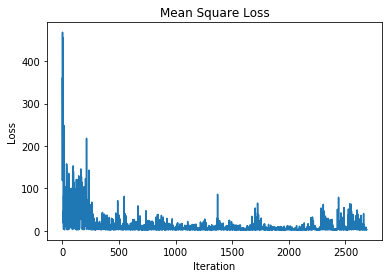

In [185]:
plt.plot(range(len(mse)), mse)
plt.title("Mean Square Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")


Text(0, 0.5, 'Loss')

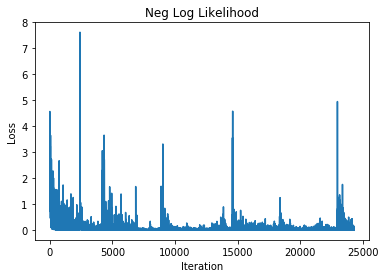

In [186]:
plt.plot(range(len(nll)), nll)
plt.title("Neg Log Likelihood")
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [187]:
torch.save(model.state_dict(), "./ptrNet_trained")
## to load:
# the_model.load_state_dict(torch.load(PATH))